In [53]:
from enum import Enum
from string import ascii_letters
from random import randint, uniform, choice, choices

import os
import json
import requests
import jsonschema
from time import perf_counter
from multiprocessing import Pool, cpu_count

from typing import Literal
from pprint import pprint  # Pretty Print for debugging

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt


SpreadsheetType = Literal["csv", "xlsx", "xls"]

formats: dict[SpreadsheetType, dict[str, str]] = {
    "csv": {"folder": "csv"},
    "xlsx": {"folder": "excel"},
    "xls": {"folder": "excel"},
}

In [21]:
def get_ranges_int(bits: int, unsigned: bool = False) -> tuple[int, int]:
    """Return the range of values for a given bit width."""
    if unsigned:
        return (0, 2**bits - 1)
    return (-(2 ** (bits - 1)), 2 ** (bits - 1) - 1)


def get_ranges_float(bits: int) -> tuple[float, float]:
    """Return the range of values for a given float bit width."""
    if bits == 32:
        return (-3.4028235e38, 3.4028235e38)

    if bits == 64:
        return (-1.7976931348623157e308, 1.7976931348623157e308)

    raise ValueError("Unsupported float bit width.")


datatype_ranges = {
    **{
        f"Int{bits}": {"type": "integer", "range": get_ranges_int(bits, False)}
        for bits in [8, 16, 32, 64, 128]
    },
    **{
        f"UInt{bits}": {"type": "integer", "range": get_ranges_int(bits, True)}
        for bits in [8, 16, 32, 64]
    },
    **{
        f"Float{bits}": {"type": "number", "range": get_ranges_float(bits)}
        for bits in [32, 64]
    },
    "Boolean": {"type": "boolean"},
    "String": {"type": "string"},
}

pprint(datatype_ranges)

{'Boolean': {'type': 'boolean'},
 'Float32': {'range': (-3.4028235e+38, 3.4028235e+38), 'type': 'number'},
 'Float64': {'range': (-1.7976931348623157e+308, 1.7976931348623157e+308),
             'type': 'number'},
 'Int128': {'range': (-170141183460469231731687303715884105728,
                      170141183460469231731687303715884105727),
            'type': 'integer'},
 'Int16': {'range': (-32768, 32767), 'type': 'integer'},
 'Int32': {'range': (-2147483648, 2147483647), 'type': 'integer'},
 'Int64': {'range': (-9223372036854775808, 9223372036854775807),
           'type': 'integer'},
 'Int8': {'range': (-128, 127), 'type': 'integer'},
 'String': {'type': 'string'},
 'UInt16': {'range': (0, 65535), 'type': 'integer'},
 'UInt32': {'range': (0, 4294967295), 'type': 'integer'},
 'UInt64': {'range': (0, 18446744073709551615), 'type': 'integer'},
 'UInt8': {'range': (0, 255), 'type': 'integer'}}


## Generate spreadsheets and its jsonschema for validation

In [22]:
def random_string(length: int = 10) -> str:
    """Generate a random string of fixed length."""
    return "".join(choice(ascii_letters) for _ in range(length))


class DataType(Enum):
    """Enum for data types."""

    # Some data types are commented out for practical purposes.
    Int8 = {
        "name": "Int8",
        "random_data": lambda: randint(*get_ranges_int(8, False)),
        "polars": pl.Int8,
    }
    Int16 = {
        "name": "Int16",
        "random_data": lambda: randint(*get_ranges_int(16, False)),
        "polars": pl.Int16,
    }
    Int32 = {
        "name": "Int32",
        "random_data": lambda: randint(*get_ranges_int(32, False)),
        "polars": pl.Int32,
    }
    # Int64 = {
    #     "name": "Int64",
    #     "random_data": lambda: randint(*get_ranges_int(64, False)),
    #     "polars": pl.Int64,
    # }
    # Int128 = {
    #     "name": "Int128",
    #     "random_data": lambda: randint(*get_ranges_int(128, False)),
    #     "polars": pl.Int128,
    # }
    UInt8 = {
        "name": "UInt8",
        "random_data": lambda: randint(*get_ranges_int(8, True)),
        "polars": pl.UInt8,
    }
    UInt16 = {
        "name": "UInt16",
        "random_data": lambda: randint(*get_ranges_int(16, True)),
        "polars": pl.UInt16,
    }
    UInt32 = {
        "name": "UInt32",
        "random_data": lambda: randint(*get_ranges_int(32, True)),
        "polars": pl.UInt32,
    }
    # UInt64 = {
    #     "name": "UInt64",
    #     "random_data": lambda: randint(*get_ranges_int(64, True)),
    #     "polars": pl.UInt64,
    # }
    Float32 = {
        "name": "Float32",
        "random_data": lambda: uniform(*get_ranges_float(32)),
        "polars": pl.Float32,
    }
    # Float64 = {
    #     "name": "Float64",
    #     "random_data": lambda: uniform(*get_ranges_float(64)),
    #     "polars": pl.Float64,
    # }
    Boolean = {
        "name": "Boolean",
        "random_data": lambda: choice([True, False]),
        "polars": pl.Boolean,
    }
    String = {
        "name": "String",
        "random_data": lambda: random_string(randint(1, 20)),
        "polars": pl.String,
    }

In [23]:
def generate_jsonschema(df: pl.DataFrame) -> dict:
    """
    Generates a JSON schema with the specified number of rows and columns.
    Each column will have a unique name and type 'integer'.
    """
    properties = {}
    for col, dtype in df.schema.items():
        dtype_str = str(dtype)
        if dtype_str not in datatype_ranges:
            print(f"Unsupported data type: {dtype_str}")
            continue

        dtype_info = datatype_ranges[dtype_str]
        properties[col] = {"type": dtype_info["type"]}
        if "range" in dtype_info:
            properties[col]["minimum"] = dtype_info["range"][0]
            properties[col]["maximum"] = dtype_info["range"][1]

    schema = {
        "$schema": "http://json-schema.org/draft-07/schema#",
        "type": "object",
        "properties": properties,
        "required": list(properties.keys()),
        "additionalProperties": False,
    }

    return schema


def generate_spreadsheet(
    rows: int, columns: int, path: str = "./data", format: SpreadsheetType = "xlsx"
) -> bool:
    """
    Generates a CSV file with the specified number of rows and columns.
    Each column will have a unique name and random integer values.
    """

    def generate_data(dtype: DataType, size: int) -> list:
        """Generate a list of random data based on the DataType."""
        return [dtype.value["random_data"]() for _ in range(size)]

    dtype_options = list(DataType)
    options = choices(dtype_options, k=columns)
    data = {
        f"col_{i}-{opt.value['name']}": pl.Series(generate_data(opt, size=rows))
        for i, opt in enumerate(options)
    }

    df = pl.DataFrame(data)

    # Save the DataFrame to a CSV file
    try:
        if format == "csv":
            df.write_csv(f"{path}/data_rows-{rows}_columns-{columns}.{format}")

        if format in ["xlsx", "xls"]:
            # Polars with floats numbers is horrible, export numbers like 1.1,3
            df.to_pandas().to_excel(
                f"{path}/data_rows-{rows}_columns-{columns}.{format}", index=False, engine='openpyxl'
            )
    except Exception as e:
        print(f"Failed to save the file in {format} format. -> {repr(e)}")
        return False

    # Save the JSON schema
    schema = generate_jsonschema(df)
    with open(f"{path}/schema_rows-{rows}_columns-{columns}.json", "w") as f:
        f.write(json.dumps(schema, indent=2))

    return True

In [24]:
# Generate csvs with fixed number of rows and varying columns
rows_fixed = 1000
format: SpreadsheetType = "csv"
path_rows = os.path.join("data", formats[format]["folder"], f"rows-{rows_fixed}")
os.makedirs(path_rows, exist_ok=True)

for i in range(100, 1001, 100):
    print(f"Generating spreadsheet with {rows_fixed} rows and {i} columns...")
    generate_spreadsheet(rows_fixed, i, path=path_rows, format=format)

Generating spreadsheet with 1000 rows and 100 columns...
Generating spreadsheet with 1000 rows and 200 columns...
Generating spreadsheet with 1000 rows and 300 columns...
Generating spreadsheet with 1000 rows and 400 columns...
Generating spreadsheet with 1000 rows and 500 columns...
Generating spreadsheet with 1000 rows and 600 columns...
Generating spreadsheet with 1000 rows and 700 columns...
Generating spreadsheet with 1000 rows and 800 columns...
Generating spreadsheet with 1000 rows and 900 columns...
Generating spreadsheet with 1000 rows and 1000 columns...


In [75]:
# Generate csvs with fixed number of columns and varying rows
columns_fixed = 100
format: SpreadsheetType = "csv"
path_columns = os.path.join("data", formats[format]["folder"], f"columns-{columns_fixed}")
os.makedirs(path_columns, exist_ok=True)
for i in range(1000, 10001, 1000):
    print(f"Generating spreadsheet with {i} rows and {columns_fixed} columns...")
    generate_spreadsheet(i, columns_fixed, path=path_columns, format=format)

Generating spreadsheet with 1000 rows and 100 columns...
Generating spreadsheet with 2000 rows and 100 columns...
Generating spreadsheet with 3000 rows and 100 columns...
Generating spreadsheet with 4000 rows and 100 columns...
Generating spreadsheet with 5000 rows and 100 columns...
Generating spreadsheet with 6000 rows and 100 columns...
Generating spreadsheet with 7000 rows and 100 columns...
Generating spreadsheet with 8000 rows and 100 columns...
Generating spreadsheet with 9000 rows and 100 columns...
Generating spreadsheet with 10000 rows and 100 columns...


In [58]:
# Big files (so much time to generate [1 GB, 3 GB, 5 GB, 7 GB])
# rows_fixed = 10_000
# path_columns = os.path.join("data", "excel", "big_files")
# os.makedirs(path_columns, exist_ok=True)
# for i in (12500, 37500, 62500, 87500):
#     print(f"Generating file with {rows_fixed} rows and {i} columns")
#     generate_spreadsheet(rows_fixed, i, path=path_columns, format="xlsx")

## Plot results

Measure time of execution

In [61]:
def validate_chunks_mp(args):
    data, schema = args
    errors = []
    valid_count = 0

    for i, item in enumerate(data):
        try:
            jsonschema.validate(instance=item, schema=schema)
            valid_count += 1
        except Exception as e:
            errors.append(f"Item {i}: {str(e)}")

    return valid_count, errors


def validate_spreadsheet_optimized(
    path: str, n_workers: int = None, schema: dict = None
) -> tuple[pl.DataFrame, dict]:
    if n_workers is None:
        n_workers = min(cpu_count(), 8)  # Limitar workers

    format = os.path.splitext(path)[-1].lower()
    if format == ".csv":
        df = pl.read_csv(path)
    if format in [".xlsx", ".xls"]:
        df = pl.read_excel(path, engine="openpyxl")

    if not schema:
        schema_path = (
            os.path.basename(path).replace(format, ".json").replace("data", "schema")
        )
        schema_path = os.path.join(os.path.dirname(path), schema_path)
        with open(schema_path, "r") as f:
            schema = json.load(f)

    data_dicts = df.to_dicts()

    chunk_size = max(1, len(data_dicts) // n_workers)
    chunks = []
    for i in range(0, len(data_dicts), chunk_size):
        chunk = data_dicts[i : i + chunk_size]
        chunks.append((chunk, schema))

    with Pool(processes=n_workers) as pool:
        results = pool.map(validate_chunks_mp, chunks)

    total_valid = sum(result[0] for result in results)
    all_errors = []
    for result in results:
        all_errors.extend(result[1])

    validation_summary = {
        "total_items": len(data_dicts),
        "valid_items": total_valid,
        "invalid_items": len(data_dicts) - total_valid,
        "errors": all_errors[:50],
    }

    return df, validation_summary


def plot_results(
    data_time: list[tuple[int, float]],
    rows: dict[str, str],  # {"x": "columns", "y": "time"}
    *,
    title: str,
    xlabel: str,
    ylabel: str,
    savefig_path: str,
) -> None:
    """
    Plot the results using seaborn and matplotlib.
    """
    df = pl.DataFrame(data_time, schema=[rows["x"], rows["y"]], orient="row")
    df = df.sort(rows["x"])

    # Create the bar plot
    ax = sns.barplot(data=df, **rows)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add text annotations for each bar
    for i, bar in enumerate(ax.patches):
        height = bar.get_height()

        # Add text annotation
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
            height + 0.1,  # y position (just above bar)
            f"{height:.1f}s",  # text (formatted time)
            ha="center",  # horizontal alignment
            va="bottom",  # vertical alignment
            fontsize=9,  # font size
        )

    plt.tight_layout()
    os.makedirs(os.path.dirname(savefig_path), exist_ok=True)
    plt.savefig(savefig_path)
    plt.show()

In [48]:
def generate_metada_from_jsonschema(
    schema: dict, table_name: str
) -> dict[str, dict[str, str]]:
    """
    Generate metadata from a JSON schema.
    The metadata will be used to create the SQL table.
    """
    dtypes = {}
    for col, properties in schema["properties"].items():
        dtype = properties["type"]
        extra = "NOT NULL" if col in schema.get("required", []) else ""
        if dtype == "integer":
            dtypes[col] = {"type": "INTEGER", "extra": extra}
        if dtype == "number":
            dtypes[col] = {"type": "FLOAT", "extra": extra}
        if dtype == "string":
            dtypes[col] = {"type": "TEXT", "extra": extra}
        if dtype == "boolean":
            dtypes[col] = {"type": "BOOLEAN", "extra": extra}

    return {table_name: dtypes}


def make_sql_request(
    file_path: str, dtypes: dict[str, dict[str, str]]
) -> dict[str, str]:
    EXCEL_PARSER_URL = "http://localhost:8001/excel-parser"
    payload = {"dtypes_str": json.dumps(dtypes)}
    files = [
        (
            "spreadsheet",
            (
                os.path.basename(file_path),
                open(file_path, "rb"),
                "application/vdn.ms-excel",
            ),
        )
    ]
    headers = {}

    response = requests.post(
        EXCEL_PARSER_URL, data=payload, files=files, headers=headers
    )

    return response.json()


### Fixed rows

In [55]:
spreadsheet_type = "xlsx"  # Change to "csv" or "xlsx" as needed
iterations = 20
rows_fixed = 1000
num_workers_rows = 16
full_rows = False

In [57]:
path_rows = os.path.join(
    "data", formats[spreadsheet_type]["folder"], f"rows-{rows_fixed}"
)
spreadsheets = os.listdir(path_rows)
results_rows = []

for i in range(iterations):
    data_time_rows: list[tuple[int, float]] = []
    print(f"Iteration {i + 1}/{iterations} for {spreadsheet_type} spreadsheets...")
    for spreadsheet in spreadsheets:
        if not spreadsheet.endswith(f".{spreadsheet_type}"):
            continue

        print(f"  [+] Validating {spreadsheet}...")
        file_path = os.path.join(path_rows, spreadsheet)

        # Read the schema from the corresponding JSON file
        format = os.path.splitext(file_path)[-1].lower()
        schema_path = (
            os.path.basename(file_path)
            .replace(format, ".json")
            .replace("data", "schema")
        )
        schema_path = os.path.join(os.path.dirname(file_path), schema_path)
        with open(schema_path, "r") as f:
            schema = json.load(f)

        start_time = perf_counter()

        print(f"  \t[+] Validating spreadsheet with {num_workers_rows} workers...", end=" ")
        df, _ = validate_spreadsheet_optimized(file_path, num_workers_rows, schema)
        print(f"{(time_validating := perf_counter() - start_time):.4f} seconds")

        if full_rows:
            print(f"  \t[+] Reading schema from {schema_path}...", end=" ")
            metadata = generate_metada_from_jsonschema(schema, "Sheet1")
            print(f"{(time_metadata := perf_counter() - start_time - time_validating):.4f} seconds")

            print("  \t[+] Making SQL request...", end=" ")
            response = make_sql_request(file_path, metadata)
            print(f"{(perf_counter() - start_time - time_metadata):.4f} seconds")
            print(response["Sheet1"])

        total_time = perf_counter() - start_time
        data_time_rows.append((df.shape[1], total_time))
        print(f"Done in {total_time:.2f} seconds.")

    results_rows.append(data_time_rows)

Iteration 1/20 for xlsx spreadsheets...
  [+] Validating data_rows-1000_columns-700.xlsx...
  	[+] Validating spreadsheet with 16 workers... 8.8294 seconds
Done in 8.83 seconds.
  [+] Validating data_rows-1000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 1.9383 seconds
Done in 1.94 seconds.
  [+] Validating data_rows-1000_columns-1000.xlsx...
  	[+] Validating spreadsheet with 16 workers... 12.3681 seconds
Done in 12.37 seconds.
  [+] Validating data_rows-1000_columns-400.xlsx...
  	[+] Validating spreadsheet with 16 workers... 5.8354 seconds
Done in 5.84 seconds.
  [+] Validating data_rows-1000_columns-500.xlsx...
  	[+] Validating spreadsheet with 16 workers... 6.5875 seconds
Done in 6.59 seconds.
  [+] Validating data_rows-1000_columns-300.xlsx...
  	[+] Validating spreadsheet with 16 workers... 3.9929 seconds
Done in 3.99 seconds.
  [+] Validating data_rows-1000_columns-900.xlsx...
  	[+] Validating spreadsheet with 16 workers... 11.5292 seconds
Done in 11.5

[(100, 1.6223312809499475),
 (200, 3.181754318250023),
 (300, 4.3541910863001245),
 (400, 5.720557989400367),
 (500, 6.586542233150067),
 (600, 7.927825922100055),
 (700, 9.195217389599929),
 (800, 10.585085446100129),
 (900, 11.791345082099905),
 (1000, 12.92981446899994)]


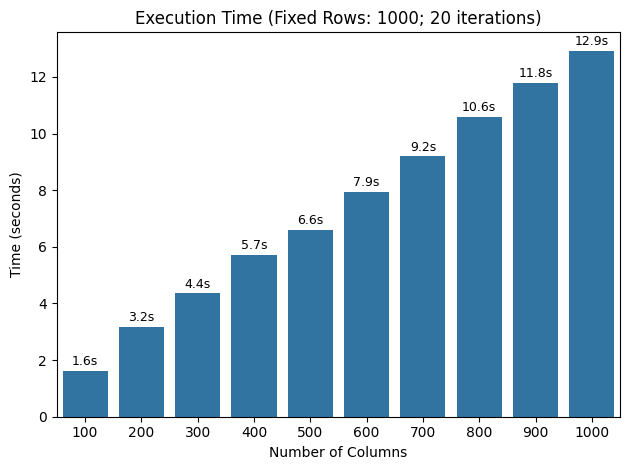

In [63]:
# Calculate the mean time for each number of columns across all iterations
results_rows = np.array(results_rows)
data_time_rows = results_rows.mean(axis=0).tolist()
data_time_rows = list(map(lambda x: (int(x[0]), float(x[1])), data_time_rows))
pprint(sorted(data_time_rows, key=lambda x: x[0]))

plot_results(
    data_time_rows,
    {"x": "columns", "y": "time"},
    title=f"Execution Time (Fixed Rows: {rows_fixed}; {iterations} iterations)",
    xlabel="Number of Columns",
    ylabel="Time (seconds)",
    savefig_path=f"figures/{formats[spreadsheet_type]['folder']}/rows-{rows_fixed}_num_workers-{num_workers_rows}_iteration-{iterations}_full-{full_rows}.pdf",
)

### Fixed columns

In [68]:
spreadsheet_type = "xlsx"
iterations = 20
columns_fixed = 100
num_workers_columns = 16
full_columns = False

In [69]:
path_columns = os.path.join(
    "data", formats[spreadsheet_type]["folder"], f"columns-{columns_fixed}"
)
spreadsheets = os.listdir(path_columns)

results_columns = []
for i in range(iterations):
    data_time_columns: list[tuple[int, float]] = []
    print(f"Iteration {i + 1}/{iterations} for {spreadsheet_type} spreadsheets...")
    for spreadsheet in spreadsheets:
        if not spreadsheet.endswith(f".{spreadsheet_type}"):
            continue

        print(f"  [+] Validating {spreadsheet}...")
        file_path = os.path.join(path_columns, spreadsheet)

        # Read the schema from the corresponding JSON file
        format = os.path.splitext(file_path)[-1].lower()
        schema_path = (
            os.path.basename(file_path)
            .replace(format, ".json")
            .replace("data", "schema")
        )
        schema_path = os.path.join(os.path.dirname(file_path), schema_path)
        with open(schema_path, "r") as f:
            schema = json.load(f)

        start_time = perf_counter()

        print(f"  \t[+] Validating spreadsheet with {num_workers_rows} workers...", end=" ")
        df, _ = validate_spreadsheet_optimized(file_path, num_workers_columns, schema)
        print(f"{(time_validating := perf_counter() - start_time):.4f} seconds")

        if full_columns:
            print(f"  \t[+] Reading schema from {schema_path}...", end=" ")
            metadata = generate_metada_from_jsonschema(schema, "Sheet1")
            print(f"{(time_metadata := perf_counter() - start_time - time_validating):.4f} seconds")

            print("  \t[+] Making SQL request...", end=" ")
            response = make_sql_request(file_path, metadata)
            print(f"{(perf_counter() - start_time - time_metadata):.4f} seconds")
            print(response["Sheet1"])

        total_time = perf_counter() - start_time
        data_time_columns.append((df.shape[0], total_time))
        print(f"Done in {total_time:.2f} seconds.")
    results_columns.append(data_time_columns)

Iteration 1/20 for xlsx spreadsheets...
  [+] Validating data_rows-4000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 6.1180 seconds
Done in 6.12 seconds.
  [+] Validating data_rows-3000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 4.4013 seconds
Done in 4.40 seconds.
  [+] Validating data_rows-1000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 1.9584 seconds
Done in 1.96 seconds.
  [+] Validating data_rows-6000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 8.1105 seconds
Done in 8.11 seconds.
  [+] Validating data_rows-5000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 7.4738 seconds
Done in 7.47 seconds.
  [+] Validating data_rows-7000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 9.6248 seconds
Done in 9.62 seconds.
  [+] Validating data_rows-8000_columns-100.xlsx...
  	[+] Validating spreadsheet with 16 workers... 10.7475 seconds
Done in 10.75 s

[(1000, 1.8888757161503236),
 (2000, 3.7346532634503093),
 (3000, 4.367674634399736),
 (4000, 6.129573994949533),
 (5000, 7.200976449649898),
 (6000, 8.147078739349855),
 (7000, 10.142938324750322),
 (8000, 10.383186999100507),
 (9000, 12.106009554400407),
 (10000, 13.254728399500163)]


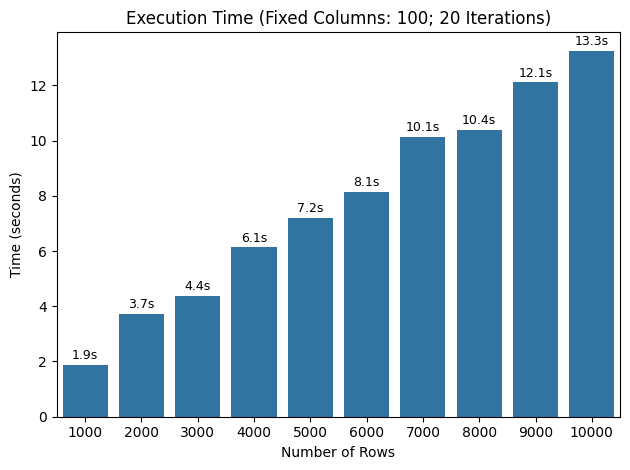

In [70]:
results_columns = np.array(results_columns)
data_time_columns = results_columns.mean(axis=0).tolist()
data_time_columns = list(map(lambda x: (int(x[0]), float(x[1])), data_time_columns))
pprint(sorted(data_time_columns, key=lambda x: x[0]))

plot_results(
    data_time_columns,
    {"x": "rows", "y": "time"},
    title=f"Execution Time (Fixed Columns: {columns_fixed}; {iterations} Iterations)",
    xlabel="Number of Rows",
    ylabel="Time (seconds)",
    savefig_path=f"figures/{formats[spreadsheet_type]['folder']}/columns-{columns_fixed}_num_workers-{num_workers_columns}_iterations-{iterations}_full-{full_columns}.pdf",
)